In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import shutil
import random

In [3]:
!pip install split-folders


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
import splitfolders

# Define the input and output paths
input_folder = "/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train"
output_folder = "/kaggle/working/dataset"

# Split the dataset into 90% train and 10% validation
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.9, 0.1), group_prefix=None)


Copying files: 223074 files [36:01, 103.22 files/s]


In [6]:
train_dir= "/kaggle/working/dataset/train"
valid_dir = "/kaggle/working/dataset/val"

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    seed=42,
    class_mode='categorical'
)

# Load validation data
validation_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)



Found 200754 images belonging to 29 classes.
Found 22320 images belonging to 29 classes.


In [13]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB1


base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(29, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           
    patience=3,           
    min_lr=1e-6           
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   
    patience=5,            
    restore_best_weights=True 
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 7,245,988 (27.64 MB)

 Trainable params: 670,749 (2.56 MB)

 Non-trainable params: 6,575,239 (25.08 MB)

In [14]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=80,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/80
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 434s 62ms/step - accuracy: 0.1147 - loss: 3.9919 - val_accuracy: 0.7062 - val_loss: 2.5294 - learning_rate: 1.0000e-05
Epoch 2/80
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 312s 50ms/step - accuracy: 0.4147 - loss: 2.7918 - val_accuracy: 0.8094 - val_loss: 1.7958 - learning_rate: 1.0000e-05
Epoch 3/80
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 311s 49ms/step - accuracy: 0.5386 - loss: 2.2618 - val_accuracy: 0.8468 - val_loss: 1.4892 - learning_rate: 1.0000e-05
Epoch 4/80
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 301s 48ms/step - accuracy: 0.6109 - loss: 1.9771 - val_accuracy: 0.8707 - val_loss: 1.3164 - learning_rate: 1.0000e-05
Epoch 5/80
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 307s 49ms/step - accuracy: 0.6544 - loss: 1.7963 - val_accuracy: 0.8848 - val_loss: 1.2000 - learning_rate: 1.0000e-05
Epoch 6/80
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 299s 48ms/step - accuracy: 0.6839 - loss: 1.6638 - val_accuracy: 0.8944 - val_loss: 1.1150 - learning_rate: 1.0000e-05
Epoch 7/80
6274/6274 ━━━━━━━━━━━━━

In [15]:
def evaluate_model(model, dataset):
    results = model.evaluate(dataset)
    print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

# Evaluate on validation set
evaluate_model(model, validation_generator)

698/698 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9709 - loss: 0.5147
Test Loss: 0.5193827748298645, Test Accuracy: 0.9687724113464355


In [19]:
def predict_image(img_path, model, class_names):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch of size 1

    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100

    return predicted_class, confidence

class_names = list(train_generator.class_indices.keys())  
print("Training dataset class names:", class_names)

# Path to the test directory containing individual images
test_dir_images = "/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_test"

correct_predictions = 0
total_predictions = 0

y_true = []  # True labels
y_pred = []  # Predicted labels

for img_name in os.listdir(test_dir_images):
    img_path = os.path.join(test_dir_images, img_name)

    if img_name.endswith(('.jpg', '.png', '.jpeg')):  

        true_label_str = img_name.split('_')[0] 
        true_label = class_names.index(true_label_str)

        predicted_class, confidence = predict_image(img_path, model, class_names)

        y_true.append(true_label)
        y_pred.append(predicted_class)

        total_predictions += 1
        if predicted_class == true_label:
            correct_predictions += 1

        print(f'Image: {img_name}, True Label: {true_label_str}, Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2f}%')

# Calculate accuracy
accuracy = correct_predictions / total_predictions * 100 if total_predictions > 0 else 0
print(f"Accuracy: {accuracy:.2f}%")

Training dataset class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: A_test.jpg, True Label: A, Predicted Class: A, Confidence: 93.18%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: E_test.jpg, True Label: E, Predicted Class: E, Confidence: 82.90%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: L_test.jpg, True Label: L, Predicted Class: L, Confidence: 99.65%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: N_test.jpg, True Label: N, Predicted Class: N, Confidence: 98.89%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: S_test.jpg, True Label: S, Predicted Class: S, Confidence: 96.41%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: D_test.jpg, True Label: D, Predicted Class: D, Confidence: 97.73%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: G_test.jpg, True Label: G, Predicted Class: G, Confidence: 99.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/st

In [21]:
y_true

[0,
 4,
 11,
 13,
 18,
 3,
 6,
 8,
 22,
 12,
 27,
 23,
 7,
 16,
 2,
 19,
 15,
 21,
 24,
 20,
 28,
 14,
 1,
 17,
 5,
 25,
 9,
 10]

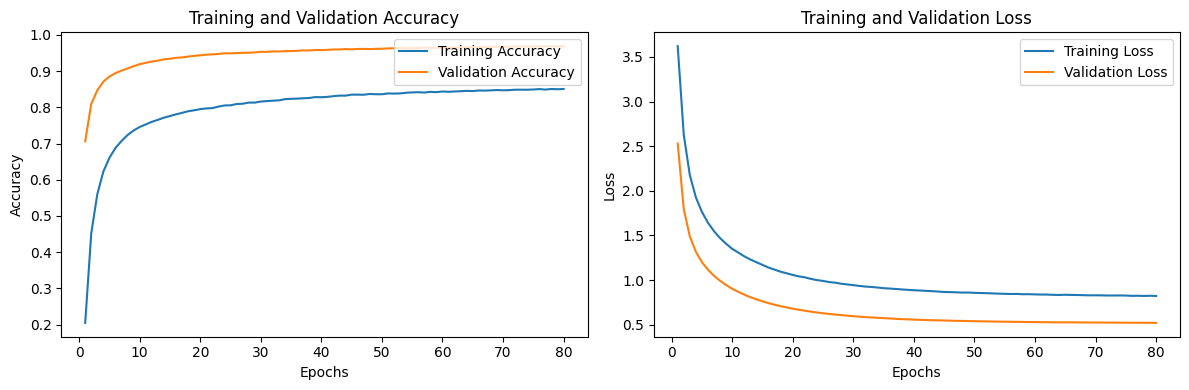

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


698/698 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step

Classification Report:
              precision    recall  f1-score   support

           A       0.94      0.98      0.96       846
           B       0.97      0.98      0.98       831
           C       0.99      0.98      0.99       815
           D       0.99      0.97      0.98       763
           E       0.95      0.95      0.95       775
           F       0.98      0.97      0.98       804
           G       0.97      0.97      0.97       785
           H       0.96      0.98      0.97       791
           I       0.97      0.93      0.95       796
           J       0.96      0.97      0.97       751
           K       0.96      0.97      0.97       788
           L       0.99      0.99      0.99       794
           M       0.96      0.94      0.95       790
           N       0.94      0.95      0.95       794
           O       0.97      0.98      0.97       814
           P       0.99      0.99      0.99       761
           Q  

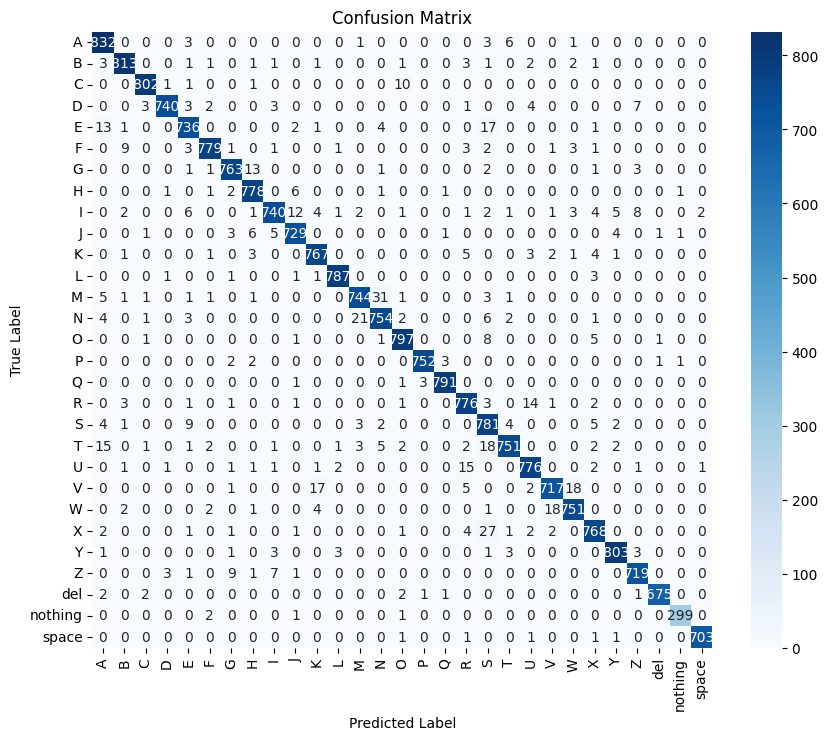

In [23]:
# Get predictions on the validation data
predictions = model.predict(validation_generator)  # Shape: (num_samples, num_classes)

# Convert predictions to class indices
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from the validation generator
y_true = validation_generator.classes  # True labels are stored in .classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [24]:
model_save_path = '/kaggle/working/Efficientnet_ASL_alphabet_detection.h5'
model.save(model_save_path)

In [25]:
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
    
download_file('/kaggle/working/Efficientnet_ASL_alphabet_detection.h5', 'out')

/kaggle/working/out.zip